In [ ]:
"""
Feature Engineering Script for NSW Real Estate Price Prediction

This script performs data cleaning, transformation, and encoding on raw
real estate sales data to prepare it for machine learning modeling.

Main Steps:
- Load raw CSV sales data.
- Drop irrelevant columns and rows with missing critical info.
- Convert dates and extract temporal features (year, month, weekday).
- Define seasons based on sale month.
- Log-transform the target variable 'Sale_Price' for normalization.
- One-hot encode categorical variables with low cardinality (Property_Use, Season).
- Label encode high cardinality categorical variables (Suburb, Street_Name, Description, Address).
- Save label encoders for later use in prediction pipeline.
- Drop unnecessary original columns after encoding.
- Save the cleaned, feature-engineered data to a CSV file for modeling.

This preprocessing ensures consistent data format and feature encoding
during both model training and inference.

Author: Ambarish Shashank Gadgil
Date: 2025-07-04
"""


import pandas as pd

df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project_1/real_estate_price_prediction/data/raw/clean_sales_data.csv')
df.head()

,Street_No,Street_Name,Suburb,Postcode,Land_Size_sqm,Contract_Date,Settlement_Date,Sale_Price,Zone,Property_Use,Description,Address
0,301,OLD NORTHERN RD,Castle Hill,2154.0,NaN,2015-05-18,2018-10-03,905000.0,NaN,R,RESIDENCE,301 OLD NORTHERN RD
1,301,OLD NORTHERN RD,Castle Hill,2154.0,NaN,2015-05-16,2018-10-11,800000.0,NaN,R,RESIDENCE,301 OLD NORTHERN RD
2,301,OLD NORTHERN RD,Castle Hill,2154.0,NaN,2015-05-16,2018-10-12,865000.0,NaN,R,RESIDENCE,301 OLD NORTHERN RD
3,7,KALIMNA DR,Baulkham Hills,2153.0,695.6,2018-08-20,2018-11-19,1040000.0,R2,R,RESIDENCE,7 KALIMNA DR
4,7,RYDAL AVE,Castle Hill,2154.0,695.6,2018-11-17,2018-12-14,1250000.0,R2,R,RESIDENCE,7 RYDAL AVE


In [17]:
#Getting the summary of daya frame

df.info()

df.dtypes
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121975 entries, 0 to 121974
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Street_No        118337 non-null  object 
 1   Street_Name      121960 non-null  object 
 2   Suburb           121975 non-null  object 
 3   Postcode         121974 non-null  float64
 4   Land_Size_sqm    42734 non-null   float64
 5   Contract_Date    121939 non-null  object 
 6   Settlement_Date  121975 non-null  object 
 7   Sale_Price       121975 non-null  float64
 8   Zone             20982 non-null   object 
 9   Property_Use     121975 non-null  object 
 10  Description      121968 non-null  object 
 11  Address          121975 non-null  object 
dtypes: float64(3), object(9)
memory usage: 11.2+ MB


,0
Street_No,3638
Street_Name,15
Suburb,0
Postcode,1
Land_Size_sqm,79241
Contract_Date,36
Settlement_Date,0
Sale_Price,0
Zone,100993
Property_Use,0


In [18]:
# Drop Zone and Land_Size_sqm
df=df.drop(columns=['Zone','Land_Size_sqm'])

# Drop rows with missing Contract_Date, Street_Name, Description
df=df.dropna(subset=['Contract_Date','Street_Name','Description'])

# Drop Street_No I don't plan to use it
df = df.drop(columns=['Street_No'])

# Reset index after drops
df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121918 entries, 0 to 121917
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Street_Name      121918 non-null  object 
 1   Suburb           121918 non-null  object 
 2   Postcode         121917 non-null  float64
 3   Contract_Date    121918 non-null  object 
 4   Settlement_Date  121918 non-null  object 
 5   Sale_Price       121918 non-null  float64
 6   Property_Use     121918 non-null  object 
 7   Description      121918 non-null  object 
 8   Address          121918 non-null  object 
dtypes: float64(2), object(7)
memory usage: 8.4+ MB


Text(0.5, 1.0, 'Log Transformed Sale Price')

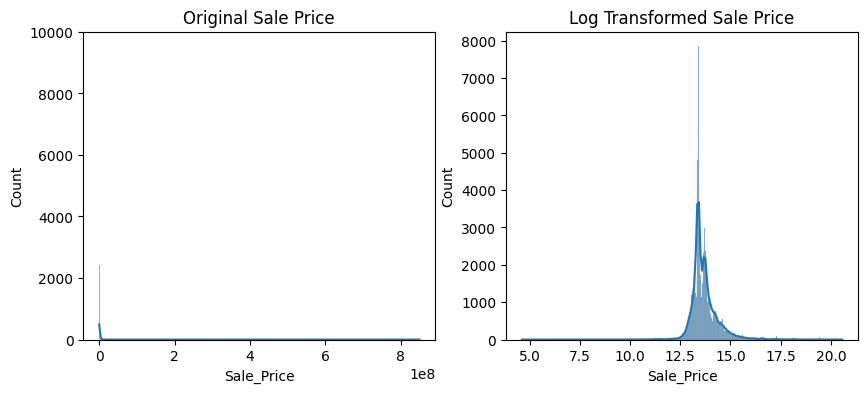

In [19]:
#lets see the sale price distribution
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Sale_Price'], kde=True)
plt.title("Original Sale Price")

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df['Sale_Price']), kde=True)
plt.title("Log Transformed Sale Price")

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Convert Contract_Date to datetime
df['Contract_Date'] = pd.to_datetime(df['Contract_Date'], errors='coerce')

# Extract temporal features
df['Sale_Year'] = df['Contract_Date'].dt.year
df['Sale_Month'] = df['Contract_Date'].dt.month
df['Sale_Weekday'] = df['Contract_Date'].dt.weekday

# Add season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df['Season'] = df['Sale_Month'].apply(get_season)

# Log Sale Price
df['Log_Sale_Price'] = np.log1p(df['Sale_Price'])

# One-hot encode low-cardinality categorical features
df = pd.get_dummies(df, columns=['Property_Use', 'Season'], drop_first=True)

# Label encode Suburb, Street_Name, Description, and Address
le_suburb = LabelEncoder()
le_street = LabelEncoder()
le_desc = LabelEncoder()
le_address = LabelEncoder()

df['Suburb_encoded'] = le_suburb.fit_transform(df['Suburb'].astype(str))
df['Street_Name_encoded'] = le_street.fit_transform(df['Street_Name'].astype(str))
df['Description_encoded'] = le_desc.fit_transform(df['Description'].astype(str))
df['Address_encoded'] = le_address.fit_transform(df['Address'].astype(str))

import pickle
import os

# Ensure the models folder exists
os.makedirs("models", exist_ok=True)

# Save encoders
with open("models/suburb_encoder.pkl", "wb") as f:
    pickle.dump(le_suburb, f)

with open("models/street_encoder.pkl", "wb") as f:
    pickle.dump(le_street, f)

with open("models/address_encoder.pkl", "wb") as f:
    pickle.dump(le_address, f)

with open("models/description_encoder.pkl", "wb") as f:
    pickle.dump(le_desc, f)



# Dropping original columns I don’t want to keep in raw form but keep the encoded versions
drop_cols = ['Contract_Date', 'Settlement_Date']
df = df.drop(columns=drop_cols)

df.head()


,Street_Name,Suburb,Postcode,Sale_Price,Description,Address,Sale_Year,Sale_Month,Sale_Weekday,Log_Sale_Price,Property_Use_R,Property_Use_V,Season_Spring,Season_Summer,Season_Winter,Suburb_encoded,Street_Name_encoded,Description_encoded,Address_encoded
0,OLD NORTHERN RD,Castle Hill,2154.0,905000.0,RESIDENCE,301 OLD NORTHERN RD,2015,5,0,13.715691,True,False,False,False,False,7,1907,61,12634
1,OLD NORTHERN RD,Castle Hill,2154.0,800000.0,RESIDENCE,301 OLD NORTHERN RD,2015,5,5,13.592368,True,False,False,False,False,7,1907,61,12634
2,OLD NORTHERN RD,Castle Hill,2154.0,865000.0,RESIDENCE,301 OLD NORTHERN RD,2015,5,5,13.670486,True,False,False,False,False,7,1907,61,12634
3,KALIMNA DR,Baulkham Hills,2153.0,1040000.0,RESIDENCE,7 KALIMNA DR,2018,8,0,13.854732,True,False,False,False,True,2,1343,61,21108
4,RYDAL AVE,Castle Hill,2154.0,1250000.0,RESIDENCE,7 RYDAL AVE,2018,11,5,14.038655,True,False,True,False,False,7,2216,61,21286


In [21]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121918 entries, 0 to 121917
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Street_Name          121918 non-null  object 
 1   Suburb               121918 non-null  object 
 2   Postcode             121917 non-null  float64
 3   Sale_Price           121918 non-null  float64
 4   Description          121918 non-null  object 
 5   Address              121918 non-null  object 
 6   Sale_Year            121918 non-null  int32  
 7   Sale_Month           121918 non-null  int32  
 8   Sale_Weekday         121918 non-null  int32  
 9   Log_Sale_Price       121918 non-null  float64
 10  Property_Use_R       121918 non-null  bool   
 11  Property_Use_V       121918 non-null  bool   
 12  Season_Spring        121918 non-null  bool   
 13  Season_Summer        121918 non-null  bool   
 14  Season_Winter        121918 non-null  bool   
 15  Suburb_encoded   

,0
Street_Name,0
Suburb,0
Postcode,1
Sale_Price,0
Description,0
Address,0
Sale_Year,0
Sale_Month,0
Sale_Weekday,0
Log_Sale_Price,0


In [22]:
# Dropping NA rows and Converting postcode to Integer
df = df.dropna(subset=['Postcode'])
df.loc[:, 'Postcode'] = df['Postcode'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121917 entries, 0 to 121917
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Street_Name          121917 non-null  object 
 1   Suburb               121917 non-null  object 
 2   Postcode             121917 non-null  float64
 3   Sale_Price           121917 non-null  float64
 4   Description          121917 non-null  object 
 5   Address              121917 non-null  object 
 6   Sale_Year            121917 non-null  int32  
 7   Sale_Month           121917 non-null  int32  
 8   Sale_Weekday         121917 non-null  int32  
 9   Log_Sale_Price       121917 non-null  float64
 10  Property_Use_R       121917 non-null  bool   
 11  Property_Use_V       121917 non-null  bool   
 12  Season_Spring        121917 non-null  bool   
 13  Season_Summer        121917 non-null  bool   
 14  Season_Winter        121917 non-null  bool   
 15  Suburb_encoded       1

In [23]:
df['Description'].value_counts()

,count
Description,
RESIDENCE,115694
COMMERCIAL,3055
VACANT LAND,874
OFFICE,858
CARSPACE,382
...,...
COLLEGE,1
PART BUILT,1
INDUSTRIAL UNI,1


In [24]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/Project_1/real_estate_price_prediction/data/processed/feature_engineered_data.csv", index=False)